$\newcommand{\vect}[1]{\boldsymbol{#1}}$

# GARCH(1,1)

THe GARCH moels has the following mean equation for the return $r_t$
\begin{align}
    r_t &= \mu + \sigma_t \cdot z_t = \mu + \epsilon_t
    \text{where } z_t \text{ are iid. } \sim N(0,1)
\end{align}
and the GARCH equation for the return variance $h_t$
\begin{align}
    \sigma_t^2 &= \omega + \alpha \cdot \epsilon_{t-1}^2 + \beta \cdot \sigma_{t-1}^2.
\end{align}
That is, the variance is linear combination of a constant $\omega$, previous squared return observed, and the previous variance. The previous squared return can be seen as a noisy observation of the variance.

Given the natural filtration $\mathcal{F}_t$, i.e. the information set at time $t$, the (conditional) return distribution is
\begin{equation}
    r_t |\mathcal{F}_t  \sim N(\mu, \sigma_t^2) \iff \epsilon_t|\mathcal{F}_t = r_t-\mu \sim N(0, \sigma_t^2).
\end{equation}
The variance $\sigma_t^2$ is known given $\mathcal{F}_{t-1}$ as per definition of the GARCH equation.

The unconditional distribution of $\epsilon_t$ and $\sigma_t^2$ are both non-gaussian, due to the fact that $\sigma_i$ is itself non-gaussian, and $\epsilon_i = \sigma_t \cdot z_t$, is the product of a non-gaussian with a gaussian variable. In fact, the unconditional distributions are leptokurtic.

### Forecasting
Given $\mathcal{F}_t$, the $s$ step ahead forecast of variance



## Parameter Estimation through maximum-likelihood estimation.

### Joint density
We are interested in the join probability distribution $f(\epsilon_1, \epsilon_2, ..., \epsilon_T; \theta)$, where $\theta := [\omega, \alpha, \beta]^T$ is the join parameter vector.

Using the fact that the join density function equals the product between the conditional and marginal density, we can write it as
\begin{align}
    f(\epsilon_1, \epsilon_2, ..., \epsilon_T; \theta) &= f(\epsilon_1; \theta) f(\epsilon_2, ..., \epsilon_T |\epsilon_1;\theta) \\
    &= f(\epsilon_1; \theta) f(\epsilon_2 | \epsilon_1;\theta) f(\epsilon_3, ..., \epsilon_T | \epsilon_1, \epsilon_2;\theta) \\
    &= f(\epsilon_1; \theta) \prod_{i=2}^T{f(\epsilon_i|\epsilon_1, ..., \epsilon_{i-1}; \theta)} \\
    &= f(\epsilon_1; \theta) \prod_{i=2}^T{f(\epsilon_i|\epsilon_{i-1}; \theta)},
\end{align}
Hence, the joint density can be factorized as the product of the marginal density for the first observation, $f(\epsilon_1; \theta)$,  and the conditional densities $f(\epsilon_i|\epsilon_{i-1}; \theta), $i=2,...,T$.

The conditional density is $f(\epsilon_i|\epsilon_{i-1}; \theta) \sim N(0, \sigma_i^2)$, where $\sigma_i$ is a known quantity given $\mathcal{F}_{i-1}$. The marginal density $f(\epsilon_1; \theta)$ is non-gaussian due to the fact that $\sigma_i$ is a random non-gaussian, and $\epsilon_i = \sigma_t \cdot z_t$, is the product of a non-gaussian with a gaussian variable. In fact, the marginal density for the innovations is leptokurtic.
### Log-likelihood function
Taking logs of the joint density we end up with the full or exact log-likelihood function. 
\begin{align}
    ln\mathcal{L}(\theta|\vect{\epsilon})_{exact} &= ln f(\epsilon_1; \theta) + \sum_{i=2}^T{ln f(\epsilon_i|\epsilon_{i-1}; \theta)} \\
    &:= ln\mathcal{L}(\theta|\epsilon_1)_{marginal} + ln\mathcal{L}(\theta|\vect{\epsilon})_{conditional}
\end{align}


==================
\begin{align}
r_t &= \sqrt{h_t} \cdot z_t \sim N(0, h_t) \\
h_t &= \omega + \alpha \cdot r_{t-1}^2 + \beta \cdot h_{t-1}
\end{align}

[1.34717745e-06 8.32516213e-02 9.10176374e-01]
1.2000492291384348
                S&P  S&P_SimpleRet  S&P_CVariance
Date                                             
2005-07-18  1221.13            NaN            NaN
2005-07-19  1229.35       0.006731       0.000045
2005-07-20  1235.20       0.004759       0.000046
2005-07-21  1227.04      -0.006606       0.000045
2005-07-22  1233.68       0.005411       0.000046


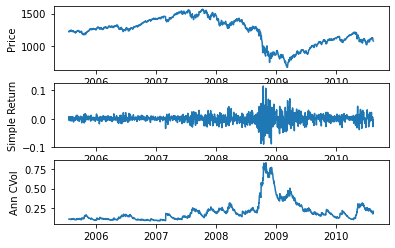

In [1]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from matplotlib import pyplot as plt

def garch_filter(param:tuple, innov:np.ndarray):
    T = len(innov)
    sigma2 = np.zeros(T)
    sigma2[0] = innov[0]**2
    for t in range(1,T):
        sigma2[t] = param[0] + param[1]*innov[t-1]**2 + param[2]*sigma2[t-1]
    return sigma2

def garch_loglike(param:tuple, innov:np.ndarray):
    sigma2 = garch_filter(param, innov)
    logL = np.average(np.log(sigma2) + innov**2/sigma2)
    return logL

def garch_loglike_jac(param:np.ndarray, innov:np.ndarray, sigma2:np.ndarray):
    T = sigma2.shape[0]
    p = param.shape[0]
    jac = np.zeros((T, p))
    var_prim = np.zeros((T, p))
    for t in range(1, T):
        var_prim[t,:] = np.array([1, innov[t-1]**2, sigma2[t-1]]) + param[2]*var_prim[t-1]
    for t in range(T):
        jac[t,:] = (1-innov[t]**2/sigma2[t])/sigma2[t] * var_prim[t]
    return np.average(jac, axis=0)

def add_simple_return(df):
    df_pct = df.pct_change().rename(columns={'S&P':'S&P_SimpleRet'})
    df = pd.concat([df, df_pct], axis=1)
    return df

# Read Data
df = pd.read_csv('data\spx.csv', sep='\t', index_col='Date')
df.index = pd.to_datetime(df.index)
df = add_simple_return(df)


# Quasi MLE Optim.
x0 = np.array([0.1, 0.4, 0.4])
bounds = ((0,1), (0,1), (0,1))
constraints = {'type':'ineq', 'fun': lambda p: 1-p[1]-p[2] }
innov = df['S&P_SimpleRet'].dropna()
# Scale up innovations due to small gradients in optim.
innov_scale = 100

# Minimize
optim_res = minimize(garch_loglike, x0, method='SLSQP', args=(innov.values*innov_scale), bounds=bounds, constraints=constraints)

# Descale parameters (weights). Only omega (Long Term Variance) affected by scaling innovations, rest invariant.
unscale = np.array([1/innov_scale**2, 1, 1])
param_est = optim_res.x * unscale
print(param_est)
print(optim_res.fun)
cond_var = garch_filter(param_est, innov)
tmp = pd.DataFrame(index=innov.index, columns=['S&P_CVariance'], data=cond_var)
df = pd.concat([df, tmp], axis=1)
print(df.head())

fig, ax = plt.subplots(3,1)
ax[0].plot(df.index, df['S&P'])
ax[0].set_ylabel('Price')

ax[1].plot(df.index, df['S&P_SimpleRet'])
ax[1].set_ylabel('Simple Return')

ax[2].plot(df.index, np.sqrt(252*df['S&P_CVariance']))
ax[2].set_ylabel('Ann CVol')
plt.show()
